Plot ROI results in figure 4, figure 5  
input: df_rois_similarity.csv  


In [30]:
from os import listdir, makedirs, walk, remove, getlogin, rename
from os.path import join, exists, isfile, getmtime, isdir
import numpy as np
import re
from brainiak import image, io, isc
from brainiak.fcma.util import compute_correlation
import brainiak.searchlight.searchlight as searchlight
from brainiak.funcalign.srm import SRM
import nibabel as nib
import time
import sys
from scipy import stats
import socket
import pandas as pd
from mpi4py import MPI
import pickle
try:  # in jupyter - load tools and run test
    from IPython.display import display
    import matplotlib.pyplot as plt
    get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina' # for 4k screen")
    from IPython.core.interactiveshell import InteractiveShell  # for var view
    InteractiveShell.ast_node_interactivity = "all"  # for var view
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})
    import pdb
    import seaborn as sns
    use_test_params=True # also clips number of voxels, skips searchlight
except ImportError:  # not jupyter
    print('Error')



In [2]:
#set paths
my_name = getlogin()

# set system
this_system = socket.gethostname()
print ('Server: '+this_system)

# DATA
bids_path='/mnt/sink/scratch/{}/to_bids'.format(my_name) # raw data
const_data_path = '/mnt/bucket/labs/hasson/'+my_name
const_study_path=join(const_data_path,'onlineL','pred20') # pre-processed data
input_fslfeat_students_path=join(const_study_path,'scan_data_nii','students_mni','6motion') # student pre-processed data
input_fslfeat_experts_path=join(const_study_path,'scan_data_nii','experts_mni','6motion') # expert pre-processed data 


print('DATA: ' + const_study_path)

# CODE
code_path='/mnt/bucket/people/{}/{}/notebooks/share'.format(my_name,my_name[:-2])
print('CODE: ' + code_path)
# SCORES
scores_path=join(bids_path,'sourcedata','exam_scores.tsv')
timing_path=join(bids_path,'sourcedata','exam_timing.tsv')
# MASKS
masks_path=join(code_path,'masks')
const_mni_brain_file_name = join(masks_path, 'MNI152_T1_3mm_brain.nii.gz')  # MNI brain
# PICKLES
pickles_path=join(const_data_path,'onlineL','shared','pickles')
csv_rois_collapsed=join(pickles_path,'df_rois_similarity.csv') # correlation between alignment and score, collapsed across students
csv_rois_non_collapsed=join(pickles_path,'df_rois_similarity_per_item.csv') # correlation between alignment and score / alignment-to-class and alignment-to-experts, not collapsed
csv_rois_raw_alignment=join(pickles_path,'df_rois_similarity_per_question_and_student.csv') # raw alignment values

print('PICKLES:' + pickles_path)

Server: scotty.pni.Princeton.EDU
DATA: /mnt/bucket/labs/hasson/meshulam/onlineL/pred20
CODE: /mnt/bucket/people/meshulam/meshul/notebooks/share
PICKLES:/mnt/bucket/labs/hasson/meshulam/onlineL/shared/pickles


In [3]:
# import multiple comparisons tools
sys.path.insert(0, join(code_path, 'py'))
from multi_comp import fdr_correction # FDR from the MNE-python package


In [4]:
def get_filtered_df(sim_roi_keys,unfiltered_df):  
    # filter df for desired results
    mask_all_cols=np.zeros(unfiltered_df.shape)
    for i_this_col,this_col in enumerate(sim_roi_keys.keys()):
        item_list=sim_roi_keys[this_col]['select']
        if item_list: # do filter
            mask_this_col=np.zeros([unfiltered_df.shape[0]])
            for this_item in range(len(sim_roi_keys[this_col]['select'])):
                mask_this_col+=(unfiltered_df[this_col]==sim_roi_keys[this_col]['select'][this_item]).values.transpose()
        else: # no filter
            mask_this_col=np.ones([unfiltered_df.shape[0]])
        mask_all_cols[:,i_this_col]=mask_this_col
    # collapse filter masks to a single vec
    mask_collapsed=np.all(mask_all_cols,axis=1)
    # filter dataframe
    this_data_outcome=unfiltered_df[mask_collapsed].copy()
    return this_data_outcome


In [13]:
# reset filter
def reset_filter (sim_roi_df=sim_roi_df):
    #zero out filter
    sim_roi_keys={}
    for this_col_name in sim_roi_df.columns:
        sim_roi_keys[this_col_name]={}
        sim_roi_keys[this_col_name]['all']=sorted(sim_roi_df[this_col_name].unique()) # all unique values in that column
        sim_roi_keys[this_col_name]['select']=None # selected value to filter
    return sim_roi_keys

   

In [ ]:
def get_title_text(sim_roi_keys,roi_name=None,roi_hemi=None):
    """
    create title for figure file/title
    """
    title_text='Similarity-'
    if roi_name or roi_hemi:
        title_text+='{}-{}-'.format(roi_name,roi_hemi)
    for i_this_col,this_col in enumerate(sim_roi_keys.keys()):
        if this_col in ['roi_hemi','roi_name']:
            pass
        else:
            item_list=sim_roi_keys[this_col]['select']
            if item_list:
                if len(item_list)>1: # do filter
                    item_list=''.join(['+'+s for s in item_list])[1:]
                else:
                    item_list=item_list[0]
            if item_list:
                title_text+=(this_col+'_'+item_list+'-')
    title_text=title_text[:-1]
    return title_text

In [6]:
def func_corr_and_null_dist(x,y,num_perms=0):
    """
    returns rval, null distribution for correlation of x,y
    """
    rval = stats.pearsonr(x,y)[0]
    pval = 1
    null_dist=None
    if num_perms>0:
        null_dist=np.array([stats.pearsonr(np.random.permutation(x), y)[0] for n in np.arange(num_perms)])
    return rval,null_dist

In [12]:
def select_keys(sim_roi_keys,roi_hemi,roi_name,vs_mean_of,sim_type,corr_w_score,subject=None,question=None):
    # helper function for filtering
    sim_roi_keys['roi_hemi']['select']=roi_hemi
    sim_roi_keys['roi_name']['select']=roi_name
    sim_roi_keys['vs_mean_of']['select']=vs_mean_of
    sim_roi_keys['sim_type']['select']=sim_type
    sim_roi_keys['corr_w_score']['select']=corr_w_score
    if subject:
        sim_roi_keys['subject']['select']=subject
    if question:
        sim_roi_keys['question']['select']=question
    return sim_roi_keys


In [7]:
#ROI regression lines 02-06-2020

# standard
thr='reg_20'


In [20]:
# load data
sim_roi_df=pd.read_csv(csv_rois_collapsed) # for all analyses, no error bars; collapsed across q and st
sim_roi_per_item_df=pd.read_csv(csv_rois_non_collapsed) # per-q and per-st data



In [21]:
# TABLE 2 results

# params
this_hemi=['bilateral']
this_roi_name=['Hippocampus','Precuneous','Cingulate-ant','Cingulate-post','Angular','Amygdala','Intracalcarine','STG-post','Heschls']

this_corr_w_score=['within']

for this_sim_type in [['diagonal'],['isfc']]:
    for this_vs_mean_of in [['student-vs-experts'],['student-vs-students']]:
        # reset and select filter keys for params
        sim_roi_df=pd.read_csv(csv_rois_collapsed)
        sim_roi_keys=select_keys(sim_roi_keys=reset_filter (sim_roi_df),roi_hemi=this_hemi,roi_name=this_roi_name,vs_mean_of=this_vs_mean_of,sim_type=this_sim_type,corr_w_score=this_corr_w_score)
        sim_roi_df=get_filtered_df(sim_roi_keys=sim_roi_keys,unfiltered_df=sim_roi_df)
        sim_roi_df['fdr_pval']= fdr_correction(sim_roi_df.pval)[1]
        sim_roi_df




,corr_w_score,score_type,sim_type,roi_type,vs_mean_of,roi_name,roi_hemi,n_voxels,rval,pval,fdr_pval
48,within,placement,diagonal,anatomical,student-vs-experts,Cingulate-ant,bilateral,1092,0.225182,0.001998,0.007992
49,within,placement,diagonal,anatomical,student-vs-experts,STG-post,bilateral,856,0.171637,0.003996,0.010656
50,within,placement,diagonal,anatomical,student-vs-experts,Angular,bilateral,1783,0.101242,0.068931,0.110290
51,within,placement,diagonal,anatomical,student-vs-experts,Heschls,bilateral,454,-0.016680,0.617383,0.796917
52,within,placement,diagonal,anatomical,student-vs-experts,Hippocampus,bilateral,668,-0.056072,0.820180,0.820180
53,within,placement,diagonal,anatomical,student-vs-experts,Amygdala,bilateral,318,-0.031076,0.697303,0.796917
54,within,placement,diagonal,anatomical,student-vs-experts,Precuneous,bilateral,2845,0.177321,0.001998,0.007992
55,within,placement,diagonal,anatomical,student-vs-experts,Intracalcarine,bilateral,925,0.116923,0.041958,0.083916


,corr_w_score,score_type,sim_type,roi_type,vs_mean_of,roi_name,roi_hemi,n_voxels,rval,pval,fdr_pval
56,within,placement,diagonal,anatomical,student-vs-students,Cingulate-ant,bilateral,1092,0.276261,0.000999,0.003996
57,within,placement,diagonal,anatomical,student-vs-students,STG-post,bilateral,856,0.250403,0.000999,0.003996
58,within,placement,diagonal,anatomical,student-vs-students,Angular,bilateral,1783,0.141042,0.013986,0.027972
59,within,placement,diagonal,anatomical,student-vs-students,Heschls,bilateral,454,0.069255,0.142857,0.163265
60,within,placement,diagonal,anatomical,student-vs-students,Hippocampus,bilateral,668,0.159018,0.007992,0.021312
61,within,placement,diagonal,anatomical,student-vs-students,Amygdala,bilateral,318,0.055548,0.207792,0.207792
62,within,placement,diagonal,anatomical,student-vs-students,Precuneous,bilateral,2845,0.104404,0.050949,0.067932
63,within,placement,diagonal,anatomical,student-vs-students,Intracalcarine,bilateral,925,0.110683,0.041958,0.067133


,corr_w_score,score_type,sim_type,roi_type,vs_mean_of,roi_name,roi_hemi,n_voxels,rval,pval,fdr_pval
32,within,placement,isfc,anatomical,student-vs-experts,Cingulate-ant,bilateral,1092,0.004283,0.478521,0.925741
33,within,placement,isfc,anatomical,student-vs-experts,STG-post,bilateral,856,0.048726,0.219780,0.586081
34,within,placement,isfc,anatomical,student-vs-experts,Angular,bilateral,1783,-0.032861,0.694306,0.925741
35,within,placement,isfc,anatomical,student-vs-experts,Heschls,bilateral,454,0.084073,0.082917,0.499500
36,within,placement,isfc,anatomical,student-vs-experts,Hippocampus,bilateral,668,-0.094964,0.936064,0.936064
37,within,placement,isfc,anatomical,student-vs-experts,Amygdala,bilateral,318,0.068499,0.124875,0.499500
38,within,placement,isfc,anatomical,student-vs-experts,Precuneous,bilateral,2845,-0.061569,0.851149,0.936064
39,within,placement,isfc,anatomical,student-vs-experts,Intracalcarine,bilateral,925,-0.023541,0.676324,0.925741


,corr_w_score,score_type,sim_type,roi_type,vs_mean_of,roi_name,roi_hemi,n_voxels,rval,pval,fdr_pval
40,within,placement,isfc,anatomical,student-vs-students,Cingulate-ant,bilateral,1092,0.214240,0.000999,0.003996
41,within,placement,isfc,anatomical,student-vs-students,STG-post,bilateral,856,0.225016,0.000999,0.003996
42,within,placement,isfc,anatomical,student-vs-students,Angular,bilateral,1783,0.170365,0.002997,0.007992
43,within,placement,isfc,anatomical,student-vs-students,Heschls,bilateral,454,0.007609,0.453546,0.518339
44,within,placement,isfc,anatomical,student-vs-students,Hippocampus,bilateral,668,0.131247,0.019980,0.039960
45,within,placement,isfc,anatomical,student-vs-students,Amygdala,bilateral,318,-0.044015,0.762238,0.762238
46,within,placement,isfc,anatomical,student-vs-students,Precuneous,bilateral,2845,0.034699,0.279720,0.372960
47,within,placement,isfc,anatomical,student-vs-students,Intracalcarine,bilateral,925,0.051026,0.218781,0.350050


In [22]:
# TABLE 3 EXAM RESULTS

# this for DIRECT
sim_roi_df=pd.read_csv(csv_rois_collapsed)
this_hemi=['bilateral']
this_corr_w_score=['direct']
this_sim_type =['diagonal']
this_vs_mean_of = ['student-vs-experts']

this_roi_name=['Hippocampus','Precuneous','Cingulate-ant','Cingulate-post','Angular','Amygdala','Heschls','STG-post','Intracalcarine']

sim_roi_keys=select_keys(sim_roi_keys=reset_filter (sim_roi_df),roi_hemi=this_hemi,roi_name=this_roi_name,vs_mean_of=this_vs_mean_of,sim_type=this_sim_type,corr_w_score=this_corr_w_score)
sim_roi_df=get_filtered_df(sim_roi_keys=sim_roi_keys,unfiltered_df=sim_roi_df)

sim_roi_df['fdr_pval']= fdr_correction(sim_roi_df.pval)[1]
sim_roi_df



,corr_w_score,score_type,sim_type,roi_type,vs_mean_of,roi_name,roi_hemi,n_voxels,rval,pval,fdr_pval
64,direct,placement,diagonal,anatomical,student-vs-experts,Cingulate-ant,bilateral,1092,0.806780,0.000999,0.000999
65,direct,placement,diagonal,anatomical,student-vs-experts,STG-post,bilateral,856,0.485019,0.000999,0.000999
66,direct,placement,diagonal,anatomical,student-vs-experts,Angular,bilateral,1783,0.488457,0.000999,0.000999
67,direct,placement,diagonal,anatomical,student-vs-experts,Heschls,bilateral,454,0.738361,0.000999,0.000999
68,direct,placement,diagonal,anatomical,student-vs-experts,Hippocampus,bilateral,668,0.466685,0.000999,0.000999
69,direct,placement,diagonal,anatomical,student-vs-experts,Amygdala,bilateral,318,0.367444,0.000999,0.000999
70,direct,placement,diagonal,anatomical,student-vs-experts,Precuneous,bilateral,2845,0.669487,0.000999,0.000999
71,direct,placement,diagonal,anatomical,student-vs-experts,Intracalcarine,bilateral,925,0.486401,0.000999,0.000999


Cingulate-ant
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


array([-1.1, -0.1,  0.9,  1.9])

array([-0.73757041, -0.06528567,  0.60699906,  1.2792838 ])

Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Alignment to experts')

(-0.5, 1.1)

(-0.5, 1.1)

Text(0.5, 1.0, 'Direct st-ex alignment corr in\nCingulate-ant-bilateral\nrval=0.807')

Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Alignment to experts')

(-0.5, 1.1)

(-0.5, 1.1)

Text(0.5, 1.0, 'Direct st-ex alignment corr in\nCingulate-ant-bilateral\nrval=0.986')

,roi_name,hemi,rval,pval,coeff_a,coeff_b,fdr_pval
0,Cingulate-ant,bilateral,0.80686,0.058824,0.672285,0.001943,0.058824


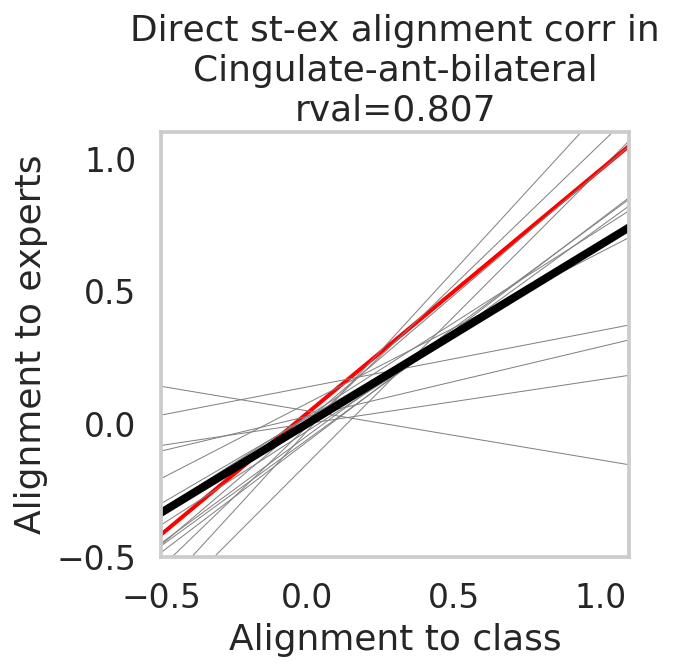

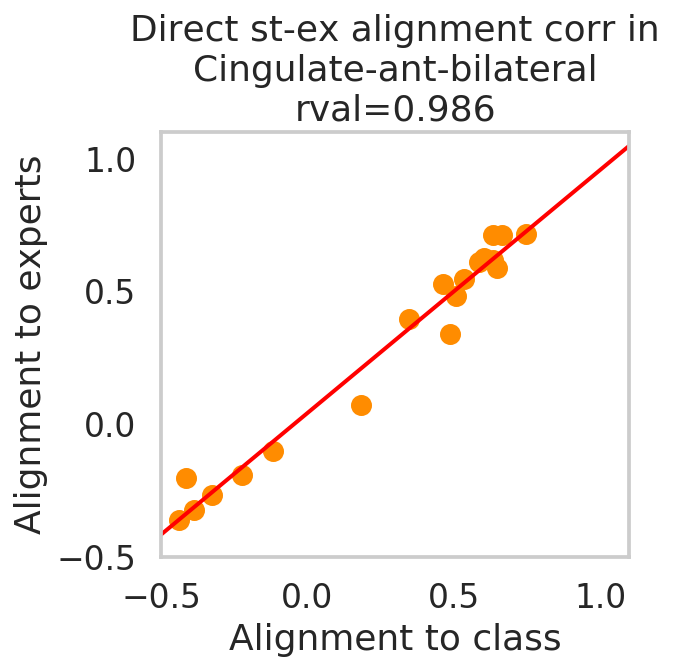

In [35]:
# Figure 3 exam results

num_perms=1000
do_plot=True
sim_roi_df=pd.read_csv(csv_rois_raw_alignment)
this_hemi=['bilateral']
this_corr_w_score=['skip']
this_sim_type =['diagonal']
#roi_names=['Hippocampus','Precuneous','Cingulate-ant','Angular','Amygdala','Heschls','STG-post','Intracalcarine']
roi_names=['Cingulate-ant']

n_questions=len(sim_roi_df.question.unique()) # 16
direct_dists=np.zeros((n_questions,num_perms)) #16 x 1000 
direct_rvals=np.zeros((n_questions)) # rval per bin
direct_pvals=np.zeros((n_questions)) #pval per bin, for jpg only
direct_coeffs=np.zeros((n_questions,2))
 
coeffs_df=pd.DataFrame() # result per bin
mean_coeffs_df=pd.DataFrame() # results mean over bins
    
for this_roi_name in [[n] for n in roi_names]:
    print(this_roi_name[0])
    for this_question in range(n_questions):
        print(this_question)
        # get st vs group data values for each question
        this_vs_mean_of = ['student-vs-students','student-vs-experts']
        sim_roi_keys=select_keys(sim_roi_keys=reset_filter (sim_roi_df),roi_hemi=this_hemi,roi_name=this_roi_name,vs_mean_of=this_vs_mean_of,sim_type=this_sim_type,corr_w_score=this_corr_w_score,question=[this_question])
        sim_roi_df_filtered=get_filtered_df(sim_roi_keys=sim_roi_keys,unfiltered_df=sim_roi_df)
        x = sim_roi_df_filtered[sim_roi_df_filtered['vs_mean_of']=='student-vs-students']['rval'].values # len students
        y = sim_roi_df_filtered[sim_roi_df_filtered['vs_mean_of']=='student-vs-experts']['rval'].values # len students
        # get r value and dist for this bin (corr(19 students))
        rval_this_q,dist_this_q=func_corr_and_null_dist(x,y,num_perms=num_perms)
        # get p value for this bin
        pval_this_q=isc.p_from_null(rval_this_q,dist_this_q,side='right',exact=False)
        # get coeffs for this bin
        regline=np.polyfit(x, y, 1)
        # save direct for this question (=bin)
        direct_rvals[this_question] = rval_this_q
        direct_pvals[this_question] =  pval_this_q
        direct_dists[this_question,:] = dist_this_q
        direct_coeffs[this_question,:] = regline
    # DF
    #save to per-q df
    temp_cdf=pd.DataFrame({'roi_name': this_roi_name[0],\
                    'hemi': this_hemi[0],\
                    'question': range(n_questions),\
                    'rval':direct_rvals,\
                    'pval':direct_pvals,\
                    'coeff_a':direct_coeffs[:,0],\
                    'coeff_b':direct_coeffs[:,1]})
    coeffs_df=coeffs_df.append(temp_cdf)

    # mean over q
    direct_dist=np.tanh(np.mean(np.arctanh(direct_dists),axis=1))
    direct_rval=np.tanh(np.mean(np.arctanh(direct_rvals))) #double
    direct_pval=isc.p_from_null(direct_rval,direct_dist,side='right',exact=False) #double
    direct_coeff_a = np.mean(direct_coeffs[:,0])
    direct_coeff_b = np.mean(direct_coeffs[:,1])
    # save to mean-over-q df
    temp_mcdf=pd.DataFrame({'roi_name': this_roi_name[0],\
                        'hemi': this_hemi[0],\
                        'rval':direct_rval,\
                        'pval':direct_pval,\
                        'coeff_a':direct_coeff_a,
                        'coeff_b':direct_coeff_b},index=[0])
    mean_coeffs_df=mean_coeffs_df.append(temp_mcdf)
        
    # PLOT
    if do_plot:
        #get q for individual scatterplot figure
        individual_qs=[1] # question number 1
        for individual_q in individual_qs: # go over top q in df
            #plot trendlines figure
            sns.set_context('talk')
            f, ax = plt.subplots(1,1, figsize = (5, 5))
            ax.grid(b=None)
            for iq in range(len(direct_rvals)):
                p=np.poly1d(direct_coeffs[iq,:])
                x=np.arange(-1.1,2.1)
                if iq==individual_q: # mark individual q in next fig in red
                    clr='red'
                    ax.plot(x,p(x),clr,linewidth=2)
                elif direct_rvals[iq]>0:
                    #clr='green'
                    clr='grey'
                    ax.plot(x,p(x),clr,linewidth=0.5) 
                else:
                    #clr='blue'  
                    clr='grey'
                    ax.plot(x,p(x),clr,linewidth=0.5)
            p=np.poly1d(np.mean(direct_coeffs,axis=0))
            x=np.arange(-1.1,2.1)
            #ax.plot(x,p(x),"red",linewidth=2)
            ax.plot(x,p(x),"black",linewidth=4) 
            x
            p(x)
            plt.xlabel('Alignment to class')
            plt.ylabel('Alignment to experts')
            plt.xlim(-0.5,1.1)
            plt.ylim(-0.5,1.1)
            #title
            ax.set_title('Direct st-ex alignment corr in\n{}-{}\nrval={:.3f}'.format(this_roi_name[0],this_hemi[0],direct_rval,fontsize=10))           
            #save
            ax.grid(b=None)
            #plt.savefig(save_filename,dpi=150)
            #plt.savefig(save_filename,dpi=150)

            # plot in individual top q 
            this_vs_mean_of = ['student-vs-students','student-vs-experts']
            sim_roi_keys=select_keys(sim_roi_keys=reset_filter (sim_roi_df),roi_hemi=this_hemi,roi_name=this_roi_name,vs_mean_of=this_vs_mean_of,sim_type=this_sim_type,corr_w_score=this_corr_w_score,question=[individual_q])
            sim_roi_df_filtered=get_filtered_df(sim_roi_keys=sim_roi_keys,unfiltered_df=sim_roi_df)
            x = sim_roi_df_filtered[sim_roi_df_filtered['vs_mean_of']=='student-vs-students']['rval'].values # len students
            y = sim_roi_df_filtered[sim_roi_df_filtered['vs_mean_of']=='student-vs-experts']['rval'].values # len students
            #plot
            sns.set_context("talk")#, font_scale=1.2)
            f, ax = plt.subplots(1,1, figsize = (5, 5))
            ax.scatter(x,y,color='darkorange')

            # trendline
            z=np.polyfit(x, y, 1)
            p = np.poly1d(z)
            pltx=np.arange(-1.1,2.1) # extend trandline to axes
            ax.plot(pltx,p(pltx),"r",linewidth=2)
            plt.xlabel('Alignment to class')
            plt.ylabel('Alignment to experts')
            plt.xlim(-0.5,1.1)
            plt.ylim(-0.5,1.1)
            this_q_rval=direct_rvals[individual_q]
            ax.set_title('Direct st-ex alignment corr in\n{}-{}\nrval={:.3f}'.format(this_roi_name[0],this_hemi[0],this_q_rval,fontsize=10))                  
            sns.set_style("whitegrid", {'axes.grid' : False})
            #save           
            #plt.savefig(save_filename,dpi=150)
            #plt.savefig(save_filename,dpi=150)

# do fdr on all rois and show df            
mean_coeffs_df['fdr_pval']=fdr_correction(mean_coeffs_df.pval)[1]
mean_coeffs_df # reproduces the table in prev cell, from raw 'skip' data
#coeffs_df


In [38]:
# read scores
def read_placement_logs(timing_path=timing_path,scores_path=scores_path):
    # read exam scores
    # returns:
    # df_q_timestamps - time stamp per question (most of the code is to get that)
    # placement_by_q - grades
    # get exam data
    scores_df=pd.read_csv(scores_path,sep='\t',index_col=[0])
    scores_df.columns=range(16)
    scores_df.index.name='Subject'
    students_ind=[True if int(i[1:])<200 else False for i,s in scores_df.iterrows() ]
    experts_ind=np.logical_not(students_ind)
    placement_by_q={}
    placement_by_q['students']=scores_df[students_ind]
    placement_by_q['experts']=scores_df[experts_ind]
    placement_by_q['students']=placement_by_q['students'].drop(['s112'], axis=0) # no placement data
    placement_by_q['experts']=placement_by_q['experts'].drop(['s201'], axis=0) # no placement data
    
    timing_df=pd.read_csv(timing_path,sep='\t',index_col=[0])
    timing_df['subject']=timing_df.index
    timing_df['student_or_expert']=['student' if int(i[1:])<200 else 'expert' for i,s in timing_df.iterrows() ]
    timing_df= timing_df.rename(columns={'question': 'q_number','response_onset_TR':'q_start_TR','response_offset_TR':'q_end_TR'})
    timing_df['q_number']-=1
    timing_df.subject=timing_df.index
    
    return timing_df,placement_by_q
    
    
df_q_timestamps, placement_by_q = read_placement_logs()

Text(0.5, 0, 'Alignment to experts')

Text(0, 0.5, 'Question score (raw)')

(-1.1, 1.1)

(-0.1, 3.1)

Text(0.5, 1.0, "Similarity corrw score in\n['Cingulate-ant']-['bilateral']\nrval=0.225,pval=0.001")

Text(0.5, 0, 'Alignment to experts')

Text(0, 0.5, 'Question score (raw)')

Text(0.5, 1.0, 'Cingulate-ant-bilateral\nsim=diagonal\nrval=0.43,pval=0.053')

(-1.1, 1.1)

(-0.1, 3.1)

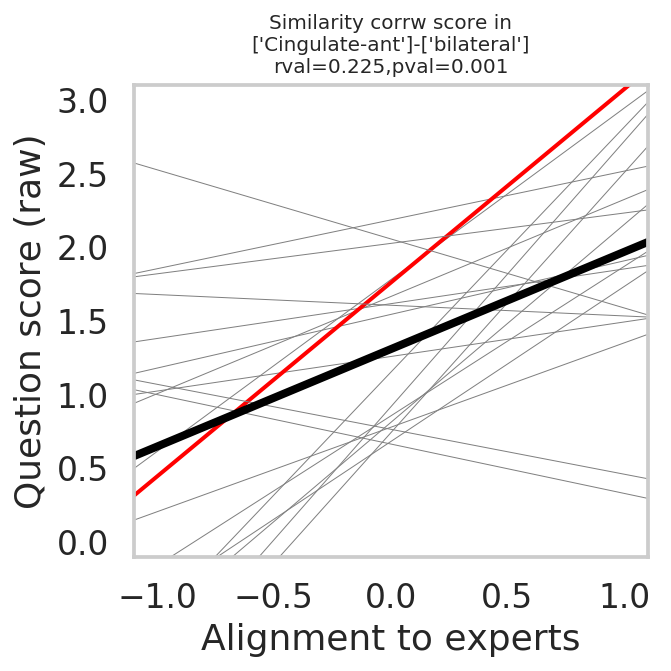

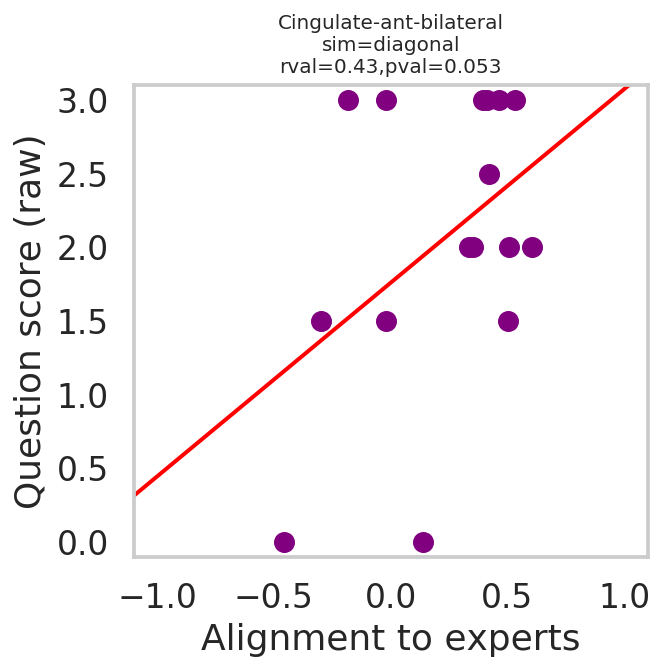

In [66]:
# FIGURE 4, FIGURE 5 RESULTS

# set parameters for different panels:
# fig 4, left (alignment-to-class)
# this_sim_type == 'diagonal' & this_vs_mean_of == 'student-vs-students'
# fig 4, right (alignment-to-experts)
# this_sim_type == 'diagonal' & this_vs_mean_of == 'student-vs-experts'
# fig 5, alignment-to-class
# this_sim_type == 'isfc' & this_vs_mean_of == 'student-vs-students'

#student = sub_s111 in all figures
# ROI = 'Cingulate-ant' in all panels

for this_sim_type in [['diagonal'],['isfc']]: # diagonal: figure 4, isfc: figure 5
    for this_vs_mean_of in [['student-vs-experts'],['student-vs-students']]:  # for figure 4, show both; for figure 5, show just student-vs-student
        # select ROI to show (anterior cingulate in manuscript)
        #for this_roi_name in [['Precuneous'],['Cingulate-ant'],['Angular'],['Hippocampus']]:
        for this_roi_name in [['Cingulate-ant']]:
            this_hemi=['bilateral']
            this_corr_w_score=['within']

            # read data, per-subject coefficients
            sim_roi_df_per_item=pd.read_csv(csv_rois_non_collapsed)

            # reset and select filter keys for params
            sim_roi_keys=select_keys(sim_roi_keys=reset_filter (sim_roi_df_per_item),roi_hemi=this_hemi,roi_name=this_roi_name,vs_mean_of=this_vs_mean_of,sim_type=this_sim_type,corr_w_score=this_corr_w_score)

            # apply filter to per-item
            sim_roi_df_per_item=get_filtered_df(sim_roi_keys=sim_roi_keys,unfiltered_df=sim_roi_df_per_item)

            # get the coeffs for trendline figure
            coeffs=np.array([sim_roi_df_per_item['coeff_a'].values,sim_roi_df_per_item['coeff_b'].values]).T

            # get the subject for indivdual scatterplot figure
            #individual_student=[np.argmax(sim_roi_df_per_item['rval'].values)] # top rval student
            #individual_students=[[i] for i in list(np.argsort(-sim_roi_df_per_item['rval'].values)[:5])] # 5 students with top rvals
            individual_students=[[7]]
            for individual_student in individual_students: # go over top students for individuals
                this_corr_w_score=['within']

                #plot trendlines figure
                sns.set_context('talk')
                f, ax = plt.subplots(1,1, figsize = (5, 5))
                #ax.grid(b=None)
                for istudent in range(coeffs.shape[0]):
                    p=np.poly1d(coeffs[istudent,:])
                    x=np.arange(-1.1,2.1)
                    if istudent==individual_student[0]: # mark individual subject in next fig in red
                        clr='red'
                        ax.plot(x,p(x),clr,linewidth=2)
                    elif coeffs[istudent,0]>0:
                        #clr='green'
                        clr='grey'
                        ax.plot(x,p(x),clr,linewidth=0.5)
                    else:
                        #clr='blue'  
                        clr='grey'
                        ax.plot(x,p(x),clr,linewidth=0.5)
                p=np.poly1d(np.mean(coeffs,axis=0))
                x=np.arange(-1.1,2.1)
                #ax.plot(x,p(x),"red",linewidth=2)
                ax.plot(x,p(x),"black",linewidth=4)
                simto= 'experts' if 'expert' in this_vs_mean_of[0] else 'class'
                plt.xlabel('Alignment to {}'.format(simto))
                plt.ylabel('Question score (raw)')
                plt.xlim(-1.1,1.1)
                plt.ylim(-0.1,3.1)

                # read mean r-value
                sim_roi_df=pd.read_csv(csv_rois_collapsed)
                sim_roi_keys=select_keys(sim_roi_keys=reset_filter (sim_roi_df),roi_hemi=this_hemi,roi_name=this_roi_name,vs_mean_of=this_vs_mean_of,sim_type=this_sim_type,corr_w_score=this_corr_w_score)
                sim_roi_df=get_filtered_df(sim_roi_keys=sim_roi_keys,unfiltered_df=sim_roi_df)

                #title
                ax.set_title('Similarity corrw score in\n{}-{}\nrval={:.3f},pval={:.3f}'.format(this_roi_name,this_hemi,np.double(sim_roi_df['rval']),np.double(sim_roi_df['pval'])),fontsize=10)
                #save
                #plt.savefig(save_filename,dpi=150)
                #plt.savefig(save_filename,dpi=150)


                #plot individual student
                # read data, per-q and per-st
                this_corr_w_score=['skip']
                sim_roi_df_per_q=pd.read_csv(csv_rois_raw_alignment)
                # reset and select filter keys for params
                sim_roi_keys=select_keys(sim_roi_keys=reset_filter (sim_roi_df_per_q),roi_hemi=this_hemi,roi_name=this_roi_name,vs_mean_of=this_vs_mean_of,sim_type=this_sim_type,corr_w_score=this_corr_w_score,subject=individual_student)
                # apply filter to per-q
                sim_roi_df_per_q=get_filtered_df(sim_roi_keys=sim_roi_keys,unfiltered_df=sim_roi_df_per_q)

                rval_from_collapsed=sim_roi_df_per_item.iloc[individual_student,]


                sns.set_context("talk")#, font_scale=1.2)
                x=sim_roi_df_per_q['rval'].values
                y=np.squeeze(placement_by_q.iloc[individual_student].values)
                rval, dist = func_corr_and_null_dist(x,y,num_perms=1000)
                assert np.abs(np.double(rval)-np.double(rval_from_collapsed['rval']))<0.001, 'rval mismatch'
                pval=isc.p_from_null(rval,dist,side='right',exact=False,axis=0)

                #plot
                f, ax = plt.subplots(1,1, figsize = (5, 5))
                ax.scatter(x,y,color='purple')
                ax.grid(b=None)
                # trendline
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                pltx=np.arange(-1.1,2.1) # extend trandline to axes
                ax.plot(pltx,p(pltx),"r",linewidth=2)
                ax.grid(b=None)
                simto= 'experts' if 'expert' in this_vs_mean_of[0] else 'class'
                plt.xlabel('Alignment to {}'.format(simto))
                plt.ylabel('Question score (raw)')
                ax.set_title('{}-{}\nsim={}\nrval={:.2f},pval={:.3f}'.format(this_roi_name[0],this_hemi[0],this_sim_type[0],rval,pval),fontsize=10)
                plt.xlim(-1.1,1.1)
                plt.ylim(-0.1,3.1)

                #save
                #plt.savefig(save_filename,dpi=150)
                #plt.savefig(save_filename,dpi=150)
